<a href="https://colab.research.google.com/github/fatemetkl/Persian-Handwritten-Image-Recognition/blob/master/FarsiNumbers-CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
! git clone https://github.com/amir-saniyan/HodaDatasetReader.git

Cloning into 'HodaDatasetReader'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24
Unpacking objects: 100% (24/24), done.


In [0]:
# *-* coding: utf-8 *-*

# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y


In [0]:
!cd HodaDatasetReader
!ls

gdrive	HodaDatasetReader  sample_data


In [0]:
print('Reading train dataset (Train 60000.cdb)...')
X_train, Y_train = read_hoda_dataset(dataset_path='./HodaDatasetReader/DigitDB/Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=False)

Reading train dataset (Train 60000.cdb)...


In [0]:
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(Y_train)
print (X_train[0].shape)

Using TensorFlow backend.


(32, 32, 1)


In [0]:
import keras 
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [0]:
model = Sequential()
#Layer 1
#Conv Layer 1
model.add(Conv2D(filters = 6, 
                 kernel_size = 5, 
                 strides = 1, 
                 activation = 'relu', 
                 input_shape = (32,32,1)))
#Pooling layer 1
model.add(MaxPooling2D(pool_size = 2, strides = 2))
#Layer 2
#Conv Layer 2
model.add(Conv2D(filters = 16, 
                 kernel_size = 5,
                 strides = 1,
                 activation = 'relu',
                 input_shape = (14,14,6)))
#Pooling Layer 2
model.add(MaxPooling2D(pool_size = 2, strides = 2))

In [0]:
#Flatten
model.add(Flatten())
#Layer 3
#Fully connected layer 1
model.add(Dense(units = 120, activation = 'relu'))
#Layer 4
#Fully connected layer 2
model.add(Dense(units = 84, activation = 'relu'))
#Layer 5
#Output Layer
model.add(Dense(units = 10, activation = 'softmax'))

In [0]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(X_train ,Y_train, steps_per_epoch = 10, epochs = 42)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/42





10/10 [==============================] - 18s 2s/step - loss: 2.0081 - acc: 0.5009
Epoch 2/42
10/10 [==============================] - 2s 227ms/step - loss: 0.9091 - acc: 0.8460
Epoch 3/42
10/10 [==============================] - 2s 227ms/step - loss: 0.3141 - acc: 0.9026
Epoch 4/42
10/10 [==============================] - 2s 227ms/step - loss: 0.2034 - acc: 0.9383
Epoch 5/42
10/10 [==============================] - 2s 228ms/step - loss: 0.1582 - acc: 0.9534
Epoch 6/42
10/10 [==============================] - 2s 226ms/step - loss: 0.1302 - acc: 0.9635
Epoch 7/42
10/10 [==============================] - 2s 227ms/step - loss: 0.1108 - acc: 0.9691
Epoch 8/42
10/10 [==============================] - 2s 231ms/step - loss: 0.0970 - acc: 0.9723
Epoch 9/42
10/10 [==============================] - 2s 229ms/step - loss: 0.0860 - acc: 0.9754
Epoch 10/42
10/10 [========================

In [0]:
print('Reading test dataset (Test 20000.cdb)...')
X_test, Y_test = read_hoda_dataset(dataset_path='./HodaDatasetReader/DigitDB/Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=False)

Reading test dataset (Test 20000.cdb)...


In [0]:
y_pred = model.predict(X_test)

#Converting one hot vectors to labels
labels = np.argmax(y_pred, axis = 1)
acc=0;

#Accuracy on test
x=[]
false_values=[]
for i in range(len(labels)):
  if labels[i]==Y_test[i]:
    acc+=1
  else:
    x=y_pred[i]
    prob_of_true=x[int(Y_test[i])]
    false_values.append((i,prob_of_true))
   
from operator import itemgetter
very_bad= sorted(false_values,key=itemgetter(1))
very_bad=very_bad[0:9]

print("ACCURACY on test =")
print(acc/len(labels))

out_img=[]
for pic in very_bad:
  out_img.append(X_test[int(pic[0])])

(528, 0.0050894953)
0.98265


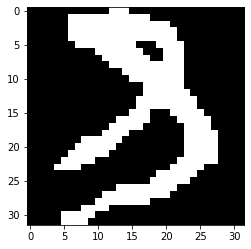

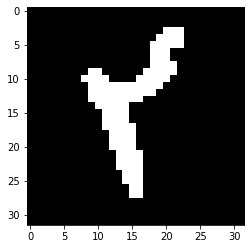

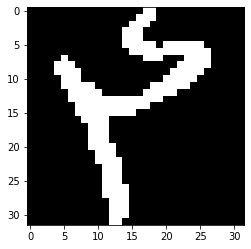

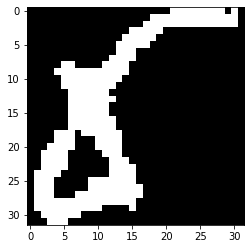

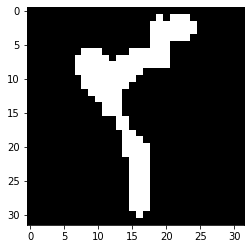

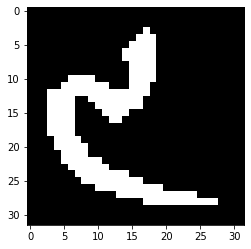

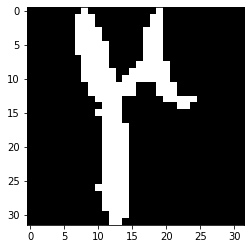

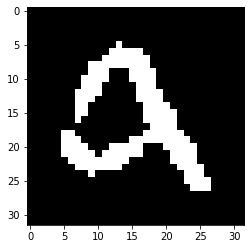

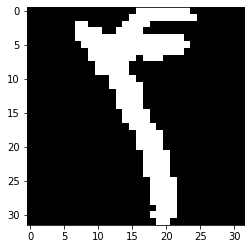

In [0]:
#Show 10 worst images

import matplotlib.pyplot as plt
for image in out_img:
  pixels = np.array(image, dtype='uint8')
  # Reshape the array into 28 x 28 array (2-dimensional array)
  pixels = pixels.reshape((32, 32))
  plt.imshow(pixels, cmap='gray')
  plt.show()

In [0]:
#confusion matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(Y_test, labels)

        print(cm)

[[1990    0    0    0    0    7    1    2    0    0]
 [   0 1997    0    0    0    0    0    2    0    1]
 [   0   13 1945   27    8    0    2    1    0    4]
 [   2    0   67 1900   28    0    2    1    0    0]
 [   0    1   12   32 1950    0    1    1    0    3]
 [   4    1    0    0    4 1982    2    2    4    1]
 [   0    3    3    0    2    7 1962    1    1   21]
 [   0    3   15    1    3    0    3 1974    0    1]
 [   0    2    1    0    0    2    1    0 1989    5]
 [   2    9    0    0    2    2   16    0    5 1964]]
